In [1]:
from blackbox37 import check
import random
import numpy as np
import math
import matplotlib.pyplot as plt
import time
%matplotlib inline

# TP : Algorithmes génétiques

#### Thomas RANVIER - Nicolas DESILETS

## I. Algorithme

Nous avons défini notre algorithme génétique au sein d'une classe afin de pouvoir en utilisant différentes instances lors de nos tests.
Une instance garde en mémoire, entre autre, les informations de temps d'exécution et de générations nécessaires pour l'ensemble des exécutions effectuées avec celle-ci.
Le but étant de définir une instance avec des paramètres définis et de l'exécuter plusieurs fois afin d'évaluer les paramètres.

Le constructeur de l'algorithme définit les paramètres utilisés, les valeurs par défauts de ces paramètres sont celles que nous avons déterminé comme étant les meilleures pour minimiser le temps d'exécution nécessaire pour trouver un mot de passe.

### 1. Génotype et phénotype

Nous avons volontairement choisi de ne pas séparer la représentation du génotype de celle du phénotype.
Ainsi, dans notre cas le génotype d'un individu est équivalent à son phénotype.

Cela fonctionne très bien dans ce cas puisqu'un individu est une simple liste de caractères et cela permet en plus à notre implémentation d'être générique.

### 2. Fonction 'run'

C'est la fonction principale de notre classe, elle permet de lancer une exécution complète de l'algorithme génétique.

Il est possible de fixer une seed pour l'aléatoire afin de pouvoir reproduire le résultat obtenu.

C'est dans cette fonction que se trouve la boucle principale de l'algorithme, on continue tant que l'on n'a pas atteint l'un des deux thresholds.
On s'arrète dès que le meilleur individu atteint la valeur de fitness fixée.
On s'arrète également si le nombre total de génération atteint la valeur maximale fixée, ce qui permet de limiter le temps maximal d'exécution d'une exécution.

La boucle se divise en trois principales étapes :
* Créer une nouvelle population avec la fonction '_selection'
* Evaluer la nouvelle population avec la fonction '_evaluate_population'
* Complétion de l'historique de l'exécution

La première population est générée de manière totalement aléatoire.

Nous avons ajouté une sécurité contre les maximums locaux au sein de cette fonction.
Lorsque l'on détecte que le meilleur individu n'a pas changé pour un certain nombre de générations on réinitialise la population de manière complétement aléatoire.
Initialement nous voulions garder une partie de la population courante afin de ne pas perdre la totalité de la progression, mais il s'avére que nous obtenons de bien meilleurs résultats en la réinitialisant à 100%.

Cette réinitialisation nous a permit de définir un taux de mutation très bas, à cause de cela l'algorithme tombe souvent dans des maximums locaux mais est si rapide que la réinitialisation compense totalement cette perte de temps.

### 3. Fonction '_evaluate_population'

Elle génére simplement une liste contenant, pour chaque individu, les valeur de fitness issuent de la fonction 'check' fournie pour ce TP.

Nous avons cependant pu grandement optimiser le temps d'exécution de cette fonction en utilisant un dictionaire globale à la classe qui permet de n'appeler la fonction 'check' qu'une seule fois par individu unique sur la totalité de l'exécution.
Cela nous a permit de réduire d'environ un tiers le temps d'exécution global de notre algorithme.

### 4. Fonction '_selection'

Elle permet de générer une nouvelle population à partir de la population courante et de son évaluation.

* La première étape consiste en trier la population courante par rapport à son évaluation.

* On peut ensuite récupérer la meilleure partie de la population courante pour l'ajouter à la nouvelle, ce que l'on appelle de l'élitisme.
  On utilise pour cela le ratio déterminé par le paramètre 'keeping_rate'.
  Nous avons découvert que garder une partie de la population courante au sein de la nouvelle améliore drastiquement les    résultats.

* On supprime ensuite la pire partie de la population courante en utilisant le ration 'cropping_rate'.
  Cela permet de ne pas garder les pires individus pour la reproduction.

* Ensuite, tant que la nouvelle population ne contient pas assez d'individus on en ajoute par reproduction.
  On sélectionne deux individus parents de manière aléatoire au sein de la population courante, en pondérant le poid de chaque individu par sa place au sein de celle-ci.
  Ainsi, les meilleurs individus ont plus de chance de se reproduire que les moins bons.
  On génére ensuite un nouvel individu enfant à partir des deux parents avec la fonction '_crossover'.
  La nouvelle entité est ajoutée à la nouvelle population.

Le ratio 'keeping_rate' permet ainsi de faire varier le facteur d'exploitation et d'exploration, il faut le choisir de manière à avoir assez de nouveaux individus à chaque génération pour une exploration suffisante mais également de manière à garder assez d'anciens individus pour ne pas ralentir la progression vers la solution optimale.

Initialement, nous sélectionnons les parents en pondérant les individus par leurs fitnesses correspondantes.
Cependant, les résultats sont bien meilleurs depuis que nous les pondérons simplement par leur place dans le classement de la population.

### 5. Fonction '_crossover'

Nous avons choisit d'effectuer un crossover en un point, permettant ainsi de garder des suites de caractères des parents et donnant donc de meilleurs résultats qu'un crossover uniforme.

Cette fonction permet de simuler une reproduction entre deux individus parents, elle est divisée en trois principales étapes :

* Sélection de la taille du nouvel individu.
  On sélectionne la taille du nouvel individu de manière aléatoire en utilisant une loi normale centrée sur la moyenne entre les tailles des deux parents.
  On obtient ainsi une taille qui a de fortes chances d'être proche de celles des parents mais qui peut tout de même varier entre les valeurs minimales et maximales de tailles.
  Nous avons trouvé qu'une loi normal avec un écart type de 1.8 donnait des valeurs convenables, cette valeur n'est pas un paramètre à faire varier, elle a été choisie de manière arbitraire et est fixée.
* Génération du nouvel individu.
  On sélectionne un point de césure entre 0 et la taille du plus petit parent.
  Le nouvel individu est généré à partir du début du premier parent jusqu'au point de césure et de la fin du second à partir du même point.
  Si le nouvel individu est plus grand que la taille précédemment déterminée on supprime certains caractères de manière aléatoire.
  S'il est plus petit que la taille prévue on ajoute des caractères aléatoires.
* Le nouvel individu passe par la fonction '_mutation' avant d'être retourné.

### 6. Fonction '_mutation'

Cette fonction permet d'ajouter des mutations à un individu.

Comme le génotype est une liste de caractères la fonction parcours chaque caractère et lui apporte une mutation avec une probabilité déterminée par le paramètre 'mutation_rate'.

Une mutation d'un caractère consiste simplement à le remplacer par un caractère aléatoire dans l'ensemble des caractères possibles, déterminés par le paramètre 'possible_chars'.

### 7. Valeurs des hyper-paramètres

Nous avons déterminé les valeurs suivantes comme étant les plus optimales.
Pour déterminer ces valeurs nous avons fait des tests que vous pourrez trouver avec plus d'explications sur nos choix plus bas dans ce notebook.

* entities_per_gen = 400.
  Il détermine le nombre d'individus qui compose une population.
* fitness_threshold = 1.
  C'est la limite à laquelle on s'arrète lorsqu'un individu d'une génération l'atteint.
  Une limite de 1 permet donc de trouver le mot de passe exact.
* max_generations = 750.
  C'est une limite de génération maximale, elle permet d'arréter le processus d'exécution après un certain nombre de génération, permettant ainsi de ne pas rester bloquer indéfiniment.
  Ce paramètre n'est plus très utile depuis que nous avons ajouté le reset de la population lorsque l'on détecte que l'on est bloqué sur un maximum local, mais nous l'avons laissé par sécurité.
* mutation_rate = .01.
  C'est la probabilité de muter chaque caractère.
* cropping_rate = .35,
  C'est le taux de la plus mauvaise partie de la population qui est supprimée avant reproduction.
* keeping_rate = .2,
  C'est le taux de la meilleure partie de la population qui est gardée lors de la reproduction.
* stuck_threshold = 50
  Si le meilleur individu n'a pas changé pendant ce nombre de générations on considère que l'on est bloqué.
  Lorsque cette limite est atteinte la totalité de la population est alors remplacée par une nouvelle complétement aléatoire.

Les autres paramètres comprennent l'id de notre groupe (9), les limites de tailles et de caractères du mot de passe cherché et les options d'affichage d'informations durant l'exécution.

In [140]:
class GA:
    """
    Class that instantiates a genetic algorithm
    """
    
    def __init__(self,
                group_id = 9,
                pass_min_length = 12,
                pass_max_length = 18,
                possible_chars = np.concatenate(([chr(i) for i in range(ord('A'), ord('Z') + 1)], 
                                                 [str(i) for i in list(range(10))])),
                entities_per_gen = 400,
                fitness_threshold = 1.,
                max_generations = 750,
                mutation_rate = .01,
                cropping_rate = .35,
                keeping_rate = .2,
                verbose = False,
                print_every = 10,
                stuck_threshold = 50
                ):
        """
        Instanciates the genetic algorithm with all its parameters and initializes its history
        
        :param group_id:            Integer 1-12, used to get a different password for each  group
        :param pass_min_length:     Integer, minimal length of the password to find
        :param pass_max_length:     Integer, maximal length of the password to find
        :param possible_chars:      List of chars, all the characters that the password can contain
        :param entities_per_gen:    Integer, number of entities in each generation
        :param fitness_threshold:   Float, defines the fitness threshold after which the run ends
        :param max_generations:     Integer, defines a security generation threshold after which the run ends
        :param mutation_rate:       Float, the mutation rate
        :param cropping_rate:       Float, rate of the lowest part of the population that is cropped before procreation
        :param keeping_rate:        Float, rate of the highest part of the population that is kept for the next generation
        :param verbose:             Boolean, if informations are displayed during the run or not
        :param print_every:         Integer, the frequency in generations at which informations are displayed if verbose = True
        :param stuck_threshold:     Integer, security threshold in generations after which part of the population is reinitialized
        """
        ## Params
        self._group_id = group_id
        self._pass_min_length = pass_min_length
        self._pass_max_length = pass_max_length
        self._possible_chars = possible_chars
        self._entities_per_gen = entities_per_gen
        self._fitness_threshold = fitness_threshold
        self._max_generations = max_generations
        self._mutation_rate = mutation_rate
        self._cropping_number = int(cropping_rate * self._entities_per_gen)
        self._keeping_number = int(keeping_rate * self._entities_per_gen)
        self._weights = [i + 1 for i in range(self._entities_per_gen - self._cropping_number)]
        self._verbose = verbose
        self._print_every = print_every
        self._stuck_threshold = stuck_threshold
        
        ## Memory of the fitness associated to each entity
        self._fitness_mem = {}
        
        ## History
        self._max_fitnesses = []
        self._mean_fitnesses = []
        self._median_fitnesses = []
        self._min_fitnesses = []
        self._best_entities = []
        self._generations = []
        self._run_times = []
        
    def run(self, seed = None):
        """
        Executes one run of the genetic algorithm
        
        :param seed:  The random seed, if seed = None then results are not reproductible
        """
        ## Set the random seed
        random.seed(seed)
        np.random.seed(seed)
        
        ## Initializes the run history
        max_fitnesses = []
        mean_fitnesses = []
        median_fitnesses = []
        min_fitnesses = []
        best_entities = []
        generation = 0
        max_fitness = 0.
        run_start_time = time.time()
        
        ## Create a new generation while none of the thresholds are reached
        while max_fitness < self._fitness_threshold and generation < self._max_generations:
            
            if generation == 0 or (len(max_fitnesses) >= self._stuck_threshold and len(set(max_fitnesses[-self._stuck_threshold:len(max_fitnesses)])) == 1):
                ## Generate fully random population if first generation or if stuck
                population = [self._random_entity() for _ in range(self._entities_per_gen)]
            else:
                ## Reproduction for new generation
                population = self._selection(population, fitnesses)
            generation += 1
            
            ## Evaluate the new population
            fitnesses = self._evaluate_population(population)
            
            ## History and logging
            max_fitness = max(fitnesses)
            max_fitnesses.append(max_fitness)
            mean_fitnesses.append(np.mean(fitnesses))
            median_fitnesses.append(np.median(fitnesses))
            min_fitnesses.append(min(fitnesses))
            best_entity = ''.join(population[np.argmax(fitnesses)])
            best_entities.append(best_entity)
            if self._verbose and generation % self._print_every == 0:
                print('Gen', generation)
                print(''.join(population[np.argmax(fitnesses)]))
                print(max(fitnesses))
        
        ## History
        self._generations.append(generation)
        self._max_fitnesses.append(max_fitnesses)
        self._mean_fitnesses.append(mean_fitnesses)
        self._median_fitnesses.append(median_fitnesses)
        self._min_fitnesses.append(min_fitnesses)
        self._best_entities.append(best_entities)
        self._run_times.append(time.time() - run_start_time)
        
        if self._verbose:
            print('## Run over ##')
        
    def run_x_times(self, x, seeds = None):
        """
        Executes x runs of the genetic algorithm
        
        :param x:      Integer, the number of runs to execute
        :param seeds:  The random seed, if seed = None then results are not reproductible 
        """
        if seeds is None or len(seeds) != x:
            seeds = [None] * x
        for i in range(x):
            self.run(seed = seeds[i])
    
    def _random_entity(self):
        """
        Generates a random entity
        
        :return: List of chars, a new random entity
        """
        ## Draw a length between the min and max length of the password
        length = random.randint(self._pass_min_length, self._pass_max_length)
        ## Draw a random char in the possible ones for each char of the new entity
        return [random.choice(self._possible_chars) for i in range(length)]
    
    def _evaluate_population(self, population):
        """
        Evaluates the passed population using the 'check' function.
        
        :param population:  List of list of chars, the population to evaluate
        :return:            List of floats, the list of the fitnesses of each individual
        """
        fitnesses = []
        for entity in population:
            ent = ''.join(entity)
            if ent not in self._fitness_mem:
                self._fitness_mem[ent] = check(self._group_id, entity)
            fitnesses.append(self._fitness_mem[ent])
        return fitnesses
    
    def _mutate(self, entity):
        """
        Maybe apply one or several mutation(s) to the entity
        
        :param entity:  List of chars, the entity to mutate
        :return:        List of chars, the resulting entity
        """
        for i in range(len(entity)):
            if random.random() <= self._mutation_rate:
                entity[i] = random.choice(self._possible_chars)
        return entity
    
    def _crossover(self, parent_1, parent_2):
        """
        Generate a child entity, given two parents entities, and then maybe apply mutation(s) to it.
        
        The length of the child entity is drawned using a normal distribution centered on the mean between
        the lengths of the two parents. By doing so, the new length have big chances to be close to the
        parents ones but can vary on all possible values.
        
        The child entity is then generated using the first part of the first parent and the second part
        of the second parent. The splitting point is randomly drawned.
        If the resulting child is longer than it should, some random characters are poped.
        If it is shorter than it should, some random characters are added.
        
        Then, mutation(s) are maybe applied to the child entity.
        
        :param parent_1:  List of chars, the first parent
        :param parent_2:  List of chars, the second parent
        :return:          List of chars, the resulting entity
        """
        min_parent = parent_1 if min(len(parent_1), len(parent_2)) == len(parent_1) else parent_2
        max_parent = parent_1 if min_parent == parent_2 else parent_2

        ## Mean between lengths of both parents
        mu = (len(min_parent) + len(max_parent)) / 2.
        ## Standard deviation
        sigma = 1.8
        ## Get random from normal distribution around mean between the lengths of both parents
        normal =  np.random.normal(mu, sigma, 1)
        new_length = max(self._pass_min_length, min(self._pass_max_length, int(round(normal[0]))))

        ## Generate child
        split_index = random.randint(0, len(min_parent))
        child_entity = min_parent[0:split_index] + max_parent[split_index:len(max_parent)]
        while new_length != len(child_entity):
            if new_length > len(child_entity):
                child_entity.insert(split_index, random.choice(self._possible_chars))
            else:
                child_entity.pop(random.randint(0, new_length))

        return self._mutate(child_entity)
    
    def _selection(self, population, fitnesses):
        """
        Generate a new population given the current one and its evaluation
        
        :param population:  List of list of chars, the current population
        :param fitnesses:   List of floats, the fitnesses of each individual
        :return:            List of list of chars, the new population
        """
        ## Sort the current population to get the worst on beginning and best on end
        population = [x for _, x in sorted(zip(fitnesses, population))]
        
        ## Start new generation by keeping best part of the current one
        new_population = population[-self._keeping_number:len(population)]
        
        ## Crop the worst part of the current population
        population = population[self._cropping_number:]

        while len(new_population) < self._entities_per_gen:
            ## Randomly pick two parents out of the pondered cropped current population
            parent_1, parent_2 = random.choices(population, weights = self._weights, k = 2)
            ## Generate the child entity
            new_entity = self._crossover(parent_1, parent_2)
            ## Add the new entity to the new population
            new_population.append(new_entity)
        return new_population
    
    @property
    def max_fitnesses(self):
        return self._max_fitnesses
    
    @property
    def mean_fitnesses(self):
        return self._mean_fitnesses
    
    @property
    def median_fitnesses(self):
        return self._median_fitnesses
    
    @property
    def min_fitnesses(self):
        return self._min_fitnesses
    
    @property
    def best_entities(self):
        return self._best_entities
    
    @property
    def generations(self):
        return self._generations
    
    @property
    def run_times(self):
        return self._run_times

## II. Démonstrations avec paramètres par défaut

### 1. Démonstration d'une simple exécution

Password:             SRIUBLODIZLA
Generations needed:   32
Time needed:          0.84 seconds


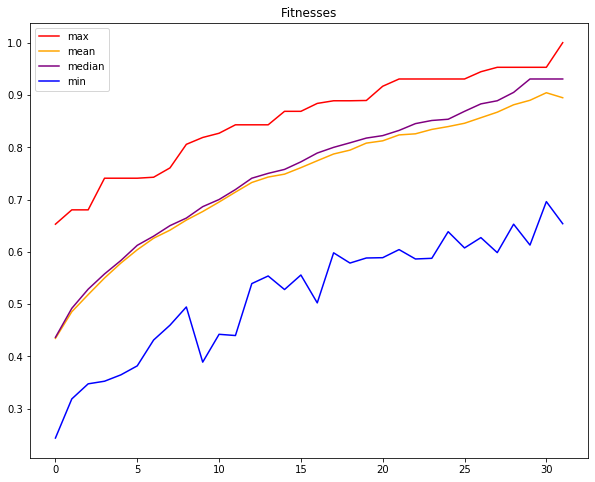

In [144]:
seed = 17
ga = GA(group_id = 5)
ga.run(seed = seed)

print('Password:            ', ga.best_entities[0][-1])
print('Generations needed:  ', ga.generations[0])
print('Time needed:         ','{:.2f} seconds'.format(ga.run_times[0]))

plt.figure(figsize=(10, 8))
plt.title('Fitnesses')
plt.plot(ga.max_fitnesses[0], color = 'red', label = 'max')
plt.plot(ga.mean_fitnesses[0], color = 'orange', label = 'mean')
plt.plot(ga.median_fitnesses[0], color = 'purple', label = 'median')
plt.plot(ga.min_fitnesses[0], color = 'blue', label = 'min')
plt.legend()
plt.show()

### 2. Démonstration sur l'ensemble des groupes possibles

In [130]:
seed = 1
for group_id in range(1, 12 + 1):
    ga = GA(group_id = group_id)
    ga.run(seed = seed)
    print('Group {:02d}: {:20s} - {:02.4f}s'.format(group_id, ga.best_entities[0][-1], ga.run_times[0]))

Group 01: Y3NW3J24QMAW2W       - 1.2859s
Group 02: GZYLGRO1FHUHUV94     - 2.2797s
Group 03: G5TX3YOH0GSBTTD      - 6.6329s
Group 04: U0L8BLSZEIRD1D0      - 10.1067s
Group 05: SRIUBLODIZLA         - 3.3905s
Group 06: A7MGWZPASISDWF       - 1.0710s
Group 07: L1UG2LNM28W4KR       - 2.0193s
Group 08: WY7QZXRKUZC1PU       - 2.2627s
Group 09: 2MZ5T0KQAC18EE3F     - 7.4984s
Group 10: 5Y0QN7ZVTZDD         - 1.3158s
Group 11: 2APFOMKJ0DLYEJD      - 6.8827s
Group 12: 29F0FS36FVWI6QG      - 1.7221s


#### Passwords:

* Group 01: Y3NW3J24QMAW2W
* Group 02: GZYLGRO1FHUHUV94
* Group 03: G5TX3YOH0GSBTTD
* Group 04: U0L8BLSZEIRD1D0
* Group 05: SRIUBLODIZLA
* Group 06: A7MGWZPASISDWF
* Group 07: L1UG2LNM28W4KR
* Group 08: WY7QZXRKUZC1PU
* Group 09: 2MZ5T0KQAC18EE3F
* Group 10: 5Y0QN7ZVTZDD
* Group 11: 2APFOMKJ0DLYEJD
* Group 12: 29F0FS36FVWI6QG

### 3. Démonstration du système de reset lors d'un blocage sur un maximum local

Password:             SRIUBLODIZLA
Generations needed:   125
Time needed:          2.51 seconds


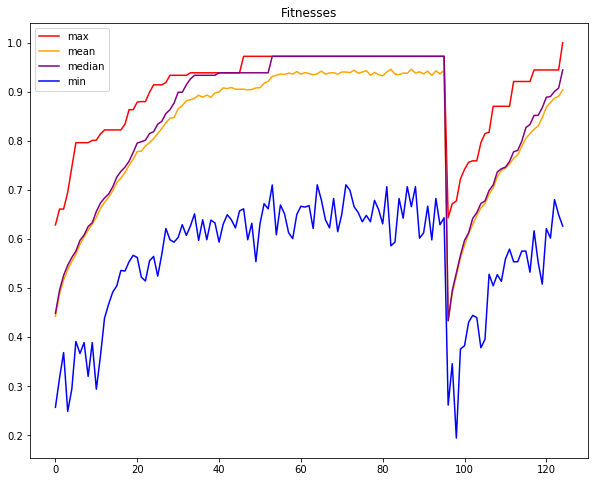

In [132]:
seed = 2
ga = GA(group_id = 5)
ga.run(seed = seed)

print('Password:            ', ga.best_entities[0][-1])
print('Generations needed:  ', ga.generations[0])
print('Time needed:         ','{:.2f} seconds'.format(ga.run_times[0]))

plt.figure(figsize=(10, 8))
plt.title('Fitnesses')
plt.plot(ga.max_fitnesses[0], color = 'red', label = 'max')
plt.plot(ga.mean_fitnesses[0], color = 'orange', label = 'mean')
plt.plot(ga.median_fitnesses[0], color = 'purple', label = 'median')
plt.plot(ga.min_fitnesses[0], color = 'blue', label = 'min')
plt.legend()
plt.show()

### 4. Démonstration des performances moyennes sur 200 exécutions sur les groupes 1, 5 et 9

Les mots de passe des groupes 1, 5 et 9 font respectivement 12, 14, et 16 caractères, ce qui nous permet de tester notre algorithmes et nos paramètres sur différentes tailles. 

Nous affichons la moyenne des temps d'exécution sur 200 exécutions pour chaque groupe, ainsi que des boites à moustaches.

Group 1 - mean run time: 7.0033369064331055
Group 5 - mean run time: 16.659199476242065
Group 9 - mean run time: 40.78538489341736


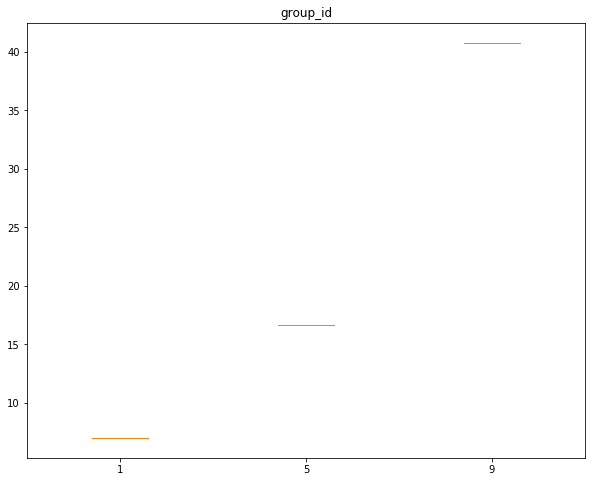

In [63]:
groups_id = [1, 5, 9]
x = 200
seeds = [i + 1 for i in range(x)]

run_times = []

for group_id in groups_id:
    ga = GA(group_id = group_id)
    ga.run_x_times(x, seeds = seeds)
    run_times.append(ga.run_times)
    print('Group id:', group_id, '- mean run time:', np.mean(ga.run_times))
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('group_id')
ax.boxplot(run_times)
ax.set_xticklabels(groups_id)
plt.show()

## III. Tests pour déterminer les meilleurs hyper-paramètres

Dans cette section nous détaillons une partie des tests que nous avons effectué pour déterminer les paramètres optimaux.

Pour déterminer la meilleure valeur d'un paramètre nous testons les résultats obtenus sur 50 exécutions avec plusieurs valeurs pour ce paramètres.
Nous affichons ensuite la moyenne du temps d'exécution et des boites à moustaches afin de pouvoir déterminer quelle est la valeur qui convient le mieu.
Nous voulons sélectionner les valeurs qui minimisent le temps d'exécution moyen et qui permette également de limiter les cas de blocage sur des maximums locaux.

Bien sûr, le principal problème de cette manière de procéder est que nous traitons les paramètres un par un.
Nous avons donc procéder à ces tests plusieurs fois en adaptant à chaque fois les paramètres par défaut pour s'approcher des paramètres optimaux.

Il faut aussi considérer que 50 exécutions ne suffisent pas à garantir que les résultats ne sont pas soumis au hasard.

Aussi, nous utilisons un group_id à 1 car ce mot de passe fait 14 caractères, cela nous permet de ne pas se baser sur des statistiques faussées (comme ce pourrait être le cas avec un mot de passe de taille minimale ou maximale).
Cela ne permet cependant pas de s'assurer que nos tests donnent des résultats qui soient adaptés aux mots de passes de n'importe quels tailles.

### 1. Nombre d'individus par générations

Il s'agit ici de l'hyper-paramètre 'entities_per_gen' qui détermine le nombre d'individu de chaque population.

On peut voir ci-dessous que les résultats sont meilleurs pour une valeur de 400.

300 6.430447516441345
350 6.033709363937378
400 5.335956859588623
450 7.220245761871338
500 6.017334251403809
550 5.517720904350281
600 6.227167129516602


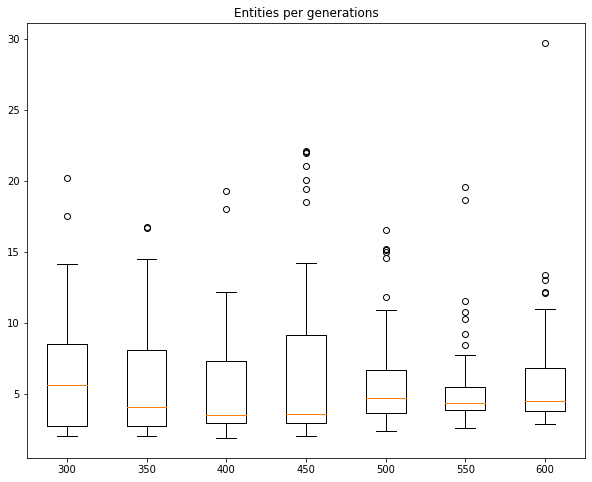

In [16]:
group_id = 1
x = 50
seeds = [i + 1 for i in range(x)]

entities_per_generations = [300, 350, 400, 450, 500, 550, 600]
run_times = []

for ent in entities_per_generations:
    ga = GA(group_id = group_id, entities_per_gen = ent)
    ga.run_x_times(x, seeds = seeds)
    run_times.append(ga.run_times)
    print('Entities per gen:', ent, '- mean run time:', np.mean(ga.run_times))
    
fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Entities per generations')
ax.boxplot(run_times)
ax.set_xticklabels(entities_per_generations)
plt.show()

### 2. Taux de la population à supprimer entre chaque génération

Il s'agit de l'hyper-paramètre 'cropping_rate'.

Ce paramètres influt beaucoup sur les résultats obtenus, il faut faire attention à ne pas le fixer trop haut, ce qui aurait pour effet de drastiquement ralentir la progression à l'approche de la solution précise.

Nous l'avons fixé à .35.

0.05 6.7936217403411865
0.1 6.533761434555053
0.15 5.487186784744263
0.2 5.116955647468567
0.25 5.038023915290832
0.3 4.833291711807251
0.35 4.5505138731002805
0.4 5.777368264198303
0.45 5.303572025299072
0.5 4.534570627212524


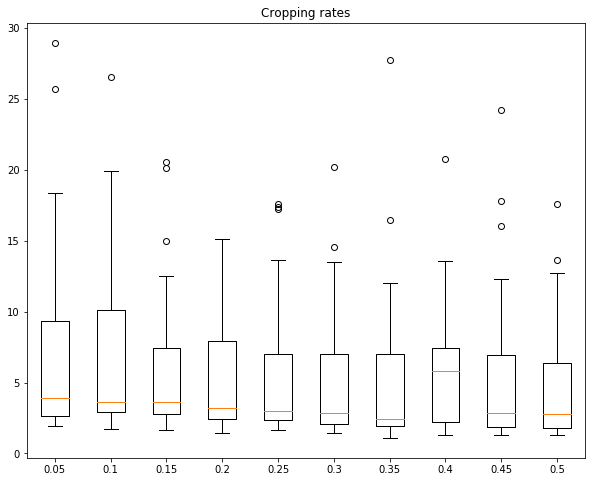

In [29]:
group_id = 1
x = 50
seeds = [i + 1 for i in range(x)]

cropping_rates = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
run_times = []

for crop in cropping_rates:
    ga = GA(group_id = group_id, cropping_rate = crop)
    ga.run_x_times(x, seeds = seeds)
    run_times.append(ga.run_times)
    print('Cropping rate:', crop, '- mean run time:', np.mean(ga.run_times))

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Cropping rates')
ax.boxplot(run_times)
ax.set_xticklabels(cropping_rates)
plt.show()

### 3. Taux de la population à garder entre chaque génération

Il s'agit de l'hyper-paramètre 'keeping_rate'.

Ce paramètre influt drastiquement sur les résultats obtenus, il fut complexe de déterminer la meilleure valeur car il dépend beaucoup de la valeur fixée pour 'cropping_rate'.

0.05 8.592507386207581
0.1 5.922759590148925
0.15 5.358478131294251
0.2 5.313088674545288
0.25 6.1709565877914425
0.3 6.318114838600159
0.35 5.063854198455811
0.4 6.188119349479675
0.45 7.2928478717803955
0.5 6.952050576210022


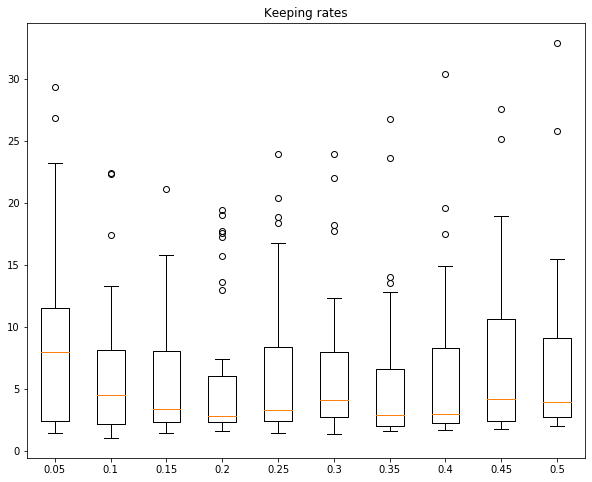

In [34]:
group_id = 1
x = 50
seeds = [i + 1 for i in range(x)]

keeping_rates = [.05, .1, .15, .2, .25, .3, .35, .4, .45, .5]
run_times = []

for keep in keeping_rates:
    ga = GA(group_id = group_id, keeping_rate = keep)
    ga.run_x_times(x, seeds = seeds)
    run_times.append(ga.run_times)
    print('Keeping rate:', keep, '- mean run time:', np.mean(ga.run_times))

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Keeping rates')
ax.boxplot(run_times)
ax.set_xticklabels(keeping_rates)
plt.show()

### 4. Taux de mutations

Il s'agit de l'hyper-paramètre 'mutation_rate'.

Nous avons rapidement déterminé qu'un taux de mutation aux alentours de 5% donnait de bons résultats.
Après plus de tests nous avons remarqué qu'un taux plus bas donnait de meilleurs résultats.

Le taux de mutation de .01 les meilleurs résultats.

0.005 5.120956592559814
0.01 4.374422097206116
0.015 5.646263308525086
0.02 5.221693654060363
0.025 6.158393969535828
0.03 4.142621483802795
0.05 5.433182468414307
0.075 6.142828574180603
0.1 6.521806807518005
0.15 12.586293864250184


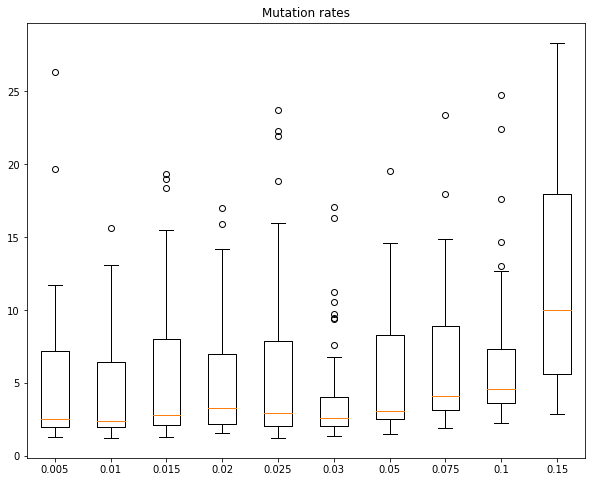

In [41]:
group_id = 1
x = 50
seeds = [i + 1 for i in range(x)]

mutation_rates = [.005, .01, .015, .02, .025, .03, .05, .075, .1, .15]
run_times = []

for mut in mutation_rates:
    ga = GA(group_id = group_id, mutation_rate = mut)
    ga.run_x_times(x, seeds = seeds)
    run_times.append(ga.run_times)
    print('Mutation rate:', mut, '- mean run time:', np.mean(ga.run_times))

fig, ax = plt.subplots(figsize=(10, 8))
ax.set_title('Mutation rates')
ax.boxplot(run_times)
ax.set_xticklabels(mutation_rates)
plt.show()